In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import csv
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


In [2]:
log_path = '/work/mwu3/drive_data/driving_log.csv'
data_folder = '/work/mwu3/drive_data/'

In [3]:
logs = []
with open(log_path,'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        logs.append(line)
log_labels = logs.pop(0)

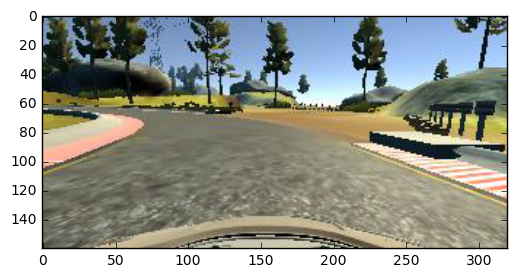

(160, 320, 3)


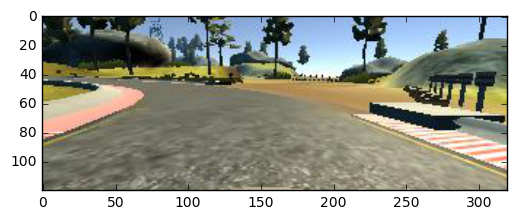

(120, 320, 3)


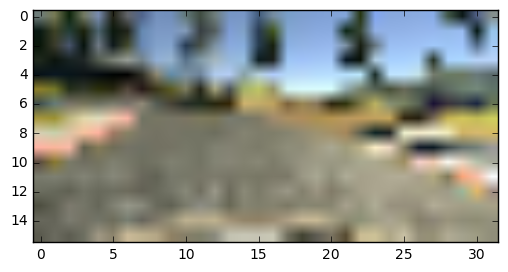

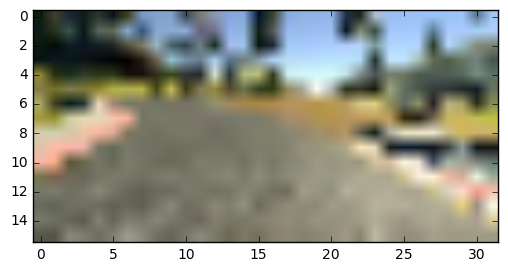

(16, 32, 3)


In [4]:
img = plt.imread(data_folder + (logs[10][0]).strip())
plt.imshow(img)
plt.show()
img_trimed = img[20:140]
print(img.shape)
plt.imshow(img_trimed)
plt.show()
print(img_trimed.shape)
img_resized = cv2.resize(img,(32,16))
plt.imshow(img_resized)
plt.show()
plt.imshow(cv2.resize(img_trimed,(32,16)))
plt.show()
print(img_resized.shape)

In [17]:
def image_trim(img):
    trimed = img[20:140]
    resized = cv2.resize(img,(32,16))
    return resized

**load and trim image**

In [18]:
def load_data(X,y,data_folder,delta=0.08):
    log_path = data_folder + 'driving_log.csv'
    logs = []
    with open(log_path,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)
    
    for i in range(len(logs)):
        img_path = logs[i][0]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_trim(img))
        y.append(float(logs[i][3]))

    for i in range(len(logs)):
        img_path = logs[i][1]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_trim(img))
        y.append(float(logs[i][3]) + delta)

    for i in range(len(logs)):
        img_path = logs[i][2]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_trim(img))
        y.append(float(logs[i][3]) - delta)

In [19]:
data={}
data['features'] = []
data['labels'] = []

load_data(data['features'], data['labels'],'/work/mwu3/drive_data/',0.15)

In [20]:
X_train = np.array(data['features']).astype('float32')
y_train = np.array(data['labels']).astype('float32')

**add more data by reflection**

In [21]:
X_train = np.append(X_train,X_train[:,:,::-1],axis=0)
y_train = np.append(y_train,-y_train,axis=0)

**split training validation and test **

In [22]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

In [23]:
print(X_train.shape)
print(X_val.shape)

(43394, 16, 32, 3)
(4822, 16, 32, 3)


In [24]:
img_size = X_train[0].shape
print(img_size)

(16, 32, 3)


**define model**

using comma.ai model (https://github.com/commaai/research/blob/master/train_steering_model.py)

In [25]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=img_size))
model.add(Conv2D(32, 3, 3, border_mode='valid', input_shape=img_size, activation='relu'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.5))
model.add(Conv2D(32, 3, 3, border_mode='valid',activation='relu'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 16, 32, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 14, 30, 32)    896         lambda_2[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 7, 15, 32)     0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 7, 15, 32)     0           maxpooling2d_3[0][0]             
___________________________________________________________________________________________

**Train**

In [26]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train, y_train,batch_size=128, nb_epoch=5,verbose=1, validation_data=(X_val, y_val))

Train on 43394 samples, validate on 4822 samples
Epoch 1/5
43394/43394 [==============================] - 3s - loss: 0.0199 - val_loss: 0.0151
Epoch 2/5
43394/43394 [==============================] - 2s - loss: 0.0157 - val_loss: 0.0135
Epoch 3/5
43394/43394 [==============================] - 2s - loss: 0.0155 - val_loss: 0.0143
Epoch 4/5
43394/43394 [==============================] - 2s - loss: 0.0150 - val_loss: 0.0138
Epoch 5/5
43394/43394 [==============================] - 2s - loss: 0.0147 - val_loss: 0.0140


In [27]:
model.predict(X_train[0:10])

array([[ 0.07722046],
       [ 0.07801646],
       [ 0.00085791],
       [ 0.12963617],
       [-0.06360853],
       [-0.11820918],
       [-0.03766277],
       [-0.0346063 ],
       [ 0.16915165],
       [ 0.03160214]], dtype=float32)

In [28]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
